In [2]:
import random
import matplotlib.pyplot as plt
import numpy as np
from docplex.mp.model import Model

Définition des paramètres

In [3]:
capacité = 100 # capacité de la camionnette du marchand de poisson
nclients = 20 # nombre de clients 
nmagasins = 3 # nombre d'emplacements possibles pour les dépôts
lbdemande = 5 # borne inférieure pour la quantité demandée par les clients
ubdemande = 25 # borne supérieure pour la quantité demandée par les clients

Génération des données aléatoires

In [5]:
# fixer le seed du random pour toujours avoir les mêmes données 
random.seed(49)
# numéro des clients  
N = [int(i) for i in range(nmagasins, nclients+nmagasins)]
# graphe V qui reprend les noeuds des emplacements + les noeuds des clients 
V = [i for i in range(nmagasins)] + N 
# génération aléatoire des quantités pour chaque client / dictionnaire : clé = numéro client, valeur = quantitié demandée 
demandes = {i:random.randint(lbdemande,ubdemande) for i in N}
# génération des coordonnées aléatoires des clients  
clients = [(random.randint(0,30),random.randint(0,30)) for _ in range(nclients)]
# génération des coordonnées aléatoires des magasins 
magasins = [(random.randint(0,30), random.randint(0,30)) for _ in range(nmagasins)] 

{3: 7, 4: 16, 5: 18, 6: 8, 7: 15, 8: 22, 9: 21, 10: 6, 11: 6, 12: 13, 13: 9, 14: 19, 15: 6, 16: 25, 17: 22, 18: 21, 19: 12, 20: 24, 21: 14, 22: 23}


Affichage des clients avec la quantité demandée et des emplacements possibles des dépôts

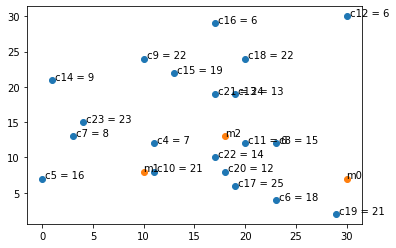

In [6]:
fig, ax = plt.subplots()
# clients axe x et axe y
xclients, yclients = [client[0] for client in clients],[client[1] for client in clients]
# magasin axe x et axe y
xmagasins, ymagasins = [magasin[0] for magasin in magasins], [magasin[1] for magasin in magasins]
ax.scatter(xclients, yclients) 
ax.scatter(xmagasins, ymagasins)
for i, q in enumerate(demandes.values()):
    ax.annotate(f' c{i+nmagasins+1} = {q}', (xclients[i],yclients[i]))
for i in range(nmagasins):
    ax.annotate(f'm{i}', (xmagasins[i],ymagasins[i]))
plt.show()

Définition du modèle

In [217]:
def ModelInit(arcs, capacité, demandes, distances, N, nmagasins):
    model = Model('CVRP')
    x = model.binary_var_dict(arcs, name = 'x') # variable binaire pour les arcs -> 0 ou 1 en fonction de si on le prend ou pas
    u = model.continuous_var_dict(N, ub = capacité, name = 'u') # ub = upperbound = capacité camionnette
    model.minimize(model.sum(distances[i,j]*x[i,j] for i,j in arcs)) # fct objectif = minimiser la distance entre les arcs qui sont pris
    model.add_constraints(model.sum(x[i,j] for j in V if j!=i) == 1 for i in N) # graphe connexe, tous les arcs doivent être liés
    model.add_constraints(model.sum(x[i,j] for i in V if i!=j) == 1 for j in N)
    model.add_indicator_constraints(model.indicator_constraint(x[i, j], u[i]+demandes[j] == u[j]) for i, j in arcs if (i not in range(nmagasins) and j not in range(nmagasins)))
    model.add_constraints(u[i] >= demandes[i] for i in N)
    # model.parameters.timelimit = 60
    return model
  

In [218]:
def solver(model):
    return model.solve(log_output = False)

Définition des arcs d'un noeud i à un noeud j et calcul de distance pour chaque arc

In [8]:
best_value = 10**10
best_magasin = None
best_solution = None

# coordonnées x et y des clients et magasins 
xtot, ytot = xclients + xmagasins, yclients + ymagasins

# initialisation des arcs du graphe -> on veut éviter d'avoir un arc d'un noeud vers lui même (i != j) et d'un dépôt vers un autre dépôt
arcs = [(i,j) for i in V for j in V if (i not in range(nmagasins) or j not in range(nmagasins) and i != j)]

# calcul des distances entre les clients et les magasins -> pour chaque arc, on obtient une distance euclidienne
dists = {(i,j): np.hypot(xtot[i]-xtot[j],ytot[i]-ytot[j]) for i,j in arcs}

model2 = ModelInit(arcs, capacité, demandes, dists, N, nmagasins)
solution2 = solver(model2)
value = solution2.objective_value
print(f'La plus petite distance à parcourir est {value}')

[(0, 3), (0, 4), (0, 5), (0, 6), (0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0, 12), (0, 13), (0, 14), (0, 15), (0, 16), (0, 17), (0, 18), (0, 19), (0, 20), (0, 21), (0, 22), (1, 3), (1, 4), (1, 5), (1, 6), (1, 7), (1, 8), (1, 9), (1, 10), (1, 11), (1, 12), (1, 13), (1, 14), (1, 15), (1, 16), (1, 17), (1, 18), (1, 19), (1, 20), (1, 21), (1, 22), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8), (2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (2, 14), (2, 15), (2, 16), (2, 17), (2, 18), (2, 19), (2, 20), (2, 21), (2, 22), (3, 0), (3, 1), (3, 2), (3, 3), (3, 4), (3, 5), (3, 6), (3, 7), (3, 8), (3, 9), (3, 10), (3, 11), (3, 12), (3, 13), (3, 14), (3, 15), (3, 16), (3, 17), (3, 18), (3, 19), (3, 20), (3, 21), (3, 22), (4, 0), (4, 1), (4, 2), (4, 3), (4, 4), (4, 5), (4, 6), (4, 7), (4, 8), (4, 9), (4, 10), (4, 11), (4, 12), (4, 13), (4, 14), (4, 15), (4, 16), (4, 17), (4, 18), (4, 19), (4, 20), (4, 21), (4, 22), (5, 0), (5, 1), (5, 2), (5, 3), (5, 4), (5, 5), (5, 6), (5, 7), (5, 8), (5, 9), (5, 10

NameError: name 'ModelInit' is not defined

In [ ]:
"""best_value = 10**10
best_magasin = None
best_solution = None
for magasin in range(nmagasins):
    xtot, ytot = add_magasin(xm[magasin],ym[magasin],xc,yc)
    arcs = [(i,j) for i in V for j in V if i!=j]
    distances = {(i,j): np.hypot(xtot[i]-xtot[j],ytot[i]-ytot[j]) for i,j in arcs}
    model = ModelInit(arcs, capacité, demandes, distances, N)
    solution = solver(model)
    value = solution.objective_value
    if value < best_value:
        best_value = value 
        best_magasin = magasin
        best_solution = solution
print(f'La plus petite distance à parcourir est {best_value}')
print(f'Le numéro du meilleur emplacement pour le magasin est {best_magasin}')"""

"best_value = 10**10\nbest_magasin = None\nbest_solution = None\nfor magasin in range(nmagasins):\n    xtot, ytot = add_magasin(xm[magasin],ym[magasin],xc,yc)\n    arcs = [(i,j) for i in V for j in V if i!=j]\n    distances = {(i,j): np.hypot(xtot[i]-xtot[j],ytot[i]-ytot[j]) for i,j in arcs}\n    model = ModelInit(arcs, capacité, demandes, distances, N)\n    solution = solver(model)\n    value = solution.objective_value\n    if value < best_value:\n        best_value = value \n        best_magasin = magasin\n        best_solution = solution\nprint(f'La plus petite distance à parcourir est {best_value}')\nprint(f'Le numéro du meilleur emplacement pour le magasin est {best_magasin}')"

In [ ]:
arcs_actifs = []
for val in (model2.iter_binary_vars()):
    if val.solution_value > 0.95:
        v = val.name.split('_')
        arcs_actifs.append((int(v[1]),int(v[2])))

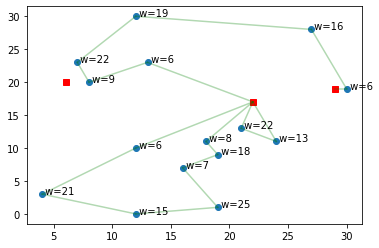

In [ ]:
fig, ax = plt.subplots() 
ax.scatter(xc[nmagasins:],yc[nmagasins:]) # affichage des clients  
for i in N:
    plt.annotate(f' w={demandes[i]}', (xc[i], yc[i]))
for i in range(nmagasins):
    xc[i],yc[i] = xm[i],ym[i]
    plt.plot(xm[i],ym[i], c='r', marker='s') # affichage des magasins
for i,j in arcs_actifs:
     plt.plot([xc[i], xc[j]], [yc[i], yc[j]], c='g', alpha=0.3)
plt.show()